In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from plot_helpers import *
from experiment import *
default_rcParams()
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 3

In [2]:
base_folder = '/scratch/pp2681/NEMO-data/'
ds = {}
ds['R4'] = Experiment(base_folder+'EXPR4_100')
ds['R9'] = Experiment(base_folder+'EXPR9_100')
ds['R4_neg'] = Experiment(base_folder+'EXPR4_final_negvisc')

In [3]:
for key in os.listdir(base_folder+'Reynolds'):
    ds[key] = Experiment(base_folder+'Reynolds/'+key)

In [4]:
ds.keys()

dict_keys(['R4', 'R9', 'R4_neg', 'CR_25', 'CR_35_2iter_4boundary', 'CR_35_2_iter', 'CR_25_2iter_4boundary', 'CR_20', 'CR_25_2iter', 'CR_25_3iter', 'CR_20_2iter', 'CR_30_2iter_4boundary'])

In [5]:
lk_error(ds['R4'].SST,ds['R9'].SST)

1.021282664278739

In [6]:
lk_error(ds['R4'].SSH,ds['R9'].SSH)

0.10806788762933223

In [7]:
lk_error(ds['R4'].EKEz,ds['R9'].EKEz)

0.008834544569253922

In [8]:
lk_error(ds['R4_neg'].EKEs,ds['R9'].EKEs)

0.027925039378186023

In [9]:
lk_error(ds['R4'].MOC,ds['R9'].MOC)

0.5029869305036283

In [10]:
lk_error(ds['R4_neg'].heat_flux2d,ds['R9'].heat_flux2d)

26754207452.15242

In [11]:
lk_error(ds['R4'].uzonal_barotropic,ds['R9'].uzonal_barotropic)

0.020960387436800232

In [12]:
lk_error(ds['R4'].uzonal_section,ds['R9'].uzonal_section)

0.06975287720778105

In [51]:
lk_error(ds['R4_neg'].heat_flux,ds['R9'].heat_flux)

13493249291801.854

# Computing all metrics

In [207]:
error = {}
for exp in ['R4', 'R4_neg', 'CR_25', 'CR_35_2iter_4boundary', 'CR_35_2_iter', 'CR_25_2iter_4boundary', 'CR_20', 'CR_25_2iter', 'CR_25_3iter', 'CR_20_2iter', 'CR_30_2iter_4boundary']:
    error[exp] = ds[exp].error(ds['R9'])
    print(exp+' finished')

R4 finished
R4_neg finished
CR_25 finished
CR_35_2iter_4boundary finished
CR_35_2_iter finished
CR_25_2iter_4boundary finished
CR_20 finished
CR_25_2iter finished
CR_25_3iter finished
CR_20_2iter finished
CR_30_2iter_4boundary finished


In [208]:
import json
with open("metrics.json", "w") as outfile:
    json.dump(error, outfile, indent=4)

# Ranking

In [209]:
def plot_2x2(fun='plot_MOC_heat', Reynolds='CR_20', error=False, wspace=0.4):
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(wspace=wspace, hspace=0.3)
    title = ['$1/4^o$', '$1/4^o$, JansenHeld', '$1/4^o$, Reynolds', '$1/9^o$']
    for j,exp in enumerate(['R4', 'R4_neg', Reynolds, 'R9']):
        plt.subplot(2,2,j+1)
        if error and j < 3:
            getattr(ds[exp], fun)(target=ds['R9'])
            plt.title(title[j]+' (error)')
        else:
            getattr(ds[exp], fun)()
            plt.title(title[j])

In [240]:
def sort_dict(d):
    return dict(sorted(d.items(), key=lambda item: item[1]))
class metrics():
    def __init__(self):
        self.error = json.load(open('metrics.json'))
    def rank_metric(self, metric, normalize=True):
        d = {}
        for exp in self.error.keys():
            d[exp] = self.error[exp][metric]
        d = sort_dict(d)
        dd = d.copy()
        if normalize:
            for key in d.keys():
                dd[key] = str(round(d[key] / d['R4'] * 100, 2))+' %'
        else:
            for key in d.keys():
                dd[key] = round(d[key],2)
        return dd
    def exp_better_than_Jansen(self, exp):
        if exp=='R4_neg':
            print('It is already JansenHeld')
            return None
        count = 0
        for key in self.error[exp].keys():
            if key != 'EKE_ratio':
                if self.error[exp][key] < self.error['R4_neg'][key]:
                    count = count + 1
            else:
                if np.abs(self.error[exp][key]-1) < np.abs(self.error['R4_neg'][key]-1):
                    count = count + 1
        return count
    def better_than_Jansen(self):
        d = {}
        for exp in self.error.keys():
            if exp != 'R4_neg':
                d[exp] = 'Better than Jansen Held in '+str(self.exp_better_than_Jansen(exp))+' metrics'
        return sort_dict(d)

In [243]:
metrics().better_than_Jansen()

{'R4': 'Better than Jansen Held in 0 metrics',
 'CR_25_2iter': 'Better than Jansen Held in 0 metrics',
 'CR_20_2iter': 'Better than Jansen Held in 0 metrics',
 'CR_25': 'Better than Jansen Held in 2 metrics',
 'CR_25_3iter': 'Better than Jansen Held in 2 metrics',
 'CR_35_2_iter': 'Better than Jansen Held in 3 metrics',
 'CR_25_2iter_4boundary': 'Better than Jansen Held in 3 metrics',
 'CR_20': 'Better than Jansen Held in 3 metrics',
 'CR_30_2iter_4boundary': 'Better than Jansen Held in 4 metrics',
 'CR_35_2iter_4boundary': 'Better than Jansen Held in 5 metrics'}

In [244]:
metrics().rank_metric('MOC')

{'R4_neg': '34.69 %',
 'CR_30_2iter_4boundary': '39.33 %',
 'CR_20': '45.05 %',
 'CR_25_3iter': '49.03 %',
 'CR_35_2iter_4boundary': '49.56 %',
 'CR_25': '50.09 %',
 'CR_25_2iter_4boundary': '52.86 %',
 'CR_35_2_iter': '55.81 %',
 'CR_25_2iter': '70.64 %',
 'CR_20_2iter': '71.8 %',
 'R4': '100.0 %'}

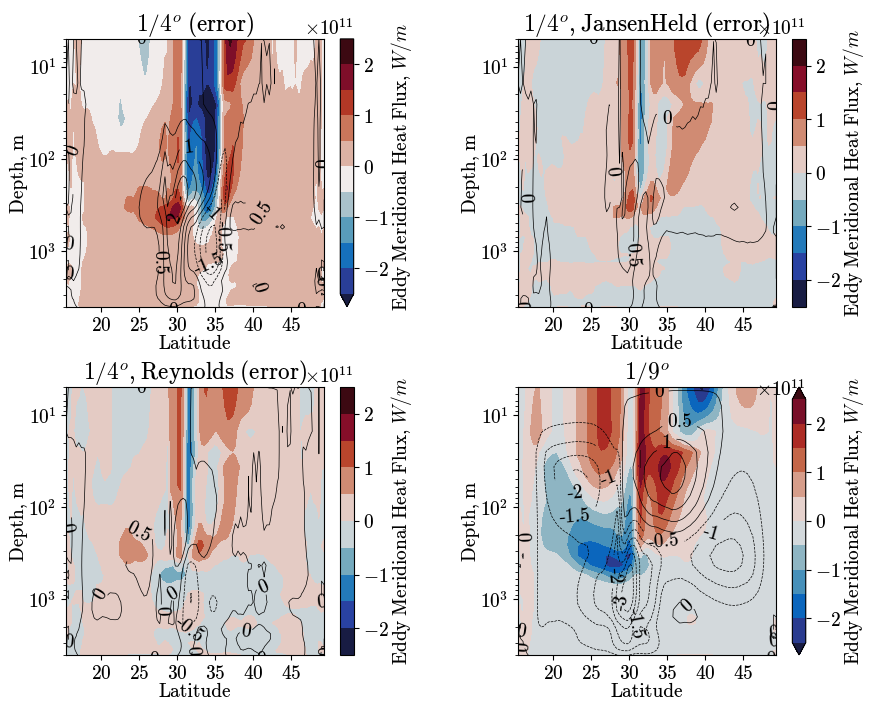

In [212]:
plot_2x2(Reynolds='CR_30_2iter_4boundary', error=True)

In [215]:
metrics().rank_metric('heat_flux2d')

{'R4_neg': '43.93 %',
 'CR_35_2iter_4boundary': '46.18 %',
 'CR_30_2iter_4boundary': '52.84 %',
 'CR_25_2iter_4boundary': '54.86 %',
 'CR_25_3iter': '57.47 %',
 'CR_35_2_iter': '59.95 %',
 'CR_20': '60.28 %',
 'CR_25': '68.97 %',
 'CR_25_2iter': '76.67 %',
 'CR_20_2iter': '81.57 %',
 'R4': '100.0 %'}

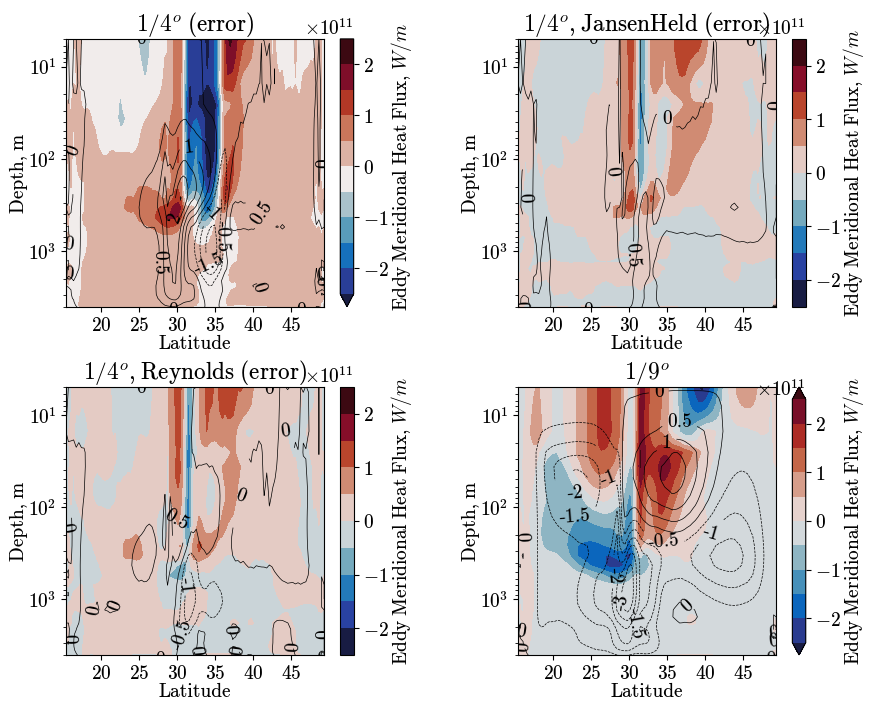

In [216]:
plot_2x2(Reynolds='CR_35_2iter_4boundary', error=True)

In [217]:
metrics().rank_metric('EKE_ratio', normalize=False)

{'R4': 0.32,
 'CR_20_2iter': 0.65,
 'CR_25_2iter': 0.75,
 'CR_35_2_iter': 0.91,
 'CR_25_2iter_4boundary': 0.91,
 'CR_30_2iter_4boundary': 1.03,
 'CR_35_2iter_4boundary': 1.06,
 'R4_neg': 1.11,
 'CR_25_3iter': 1.13,
 'CR_20': 1.29,
 'CR_25': 1.47}

In [218]:
metrics().rank_metric('EKEz')

{'CR_30_2iter_4boundary': '10.3 %',
 'CR_25_2iter_4boundary': '12.07 %',
 'CR_35_2_iter': '12.79 %',
 'CR_35_2iter_4boundary': '15.64 %',
 'R4_neg': '20.57 %',
 'CR_25_3iter': '29.53 %',
 'CR_25_2iter': '34.97 %',
 'CR_20_2iter': '49.01 %',
 'CR_20': '51.97 %',
 'CR_25': '80.17 %',
 'R4': '100.0 %'}

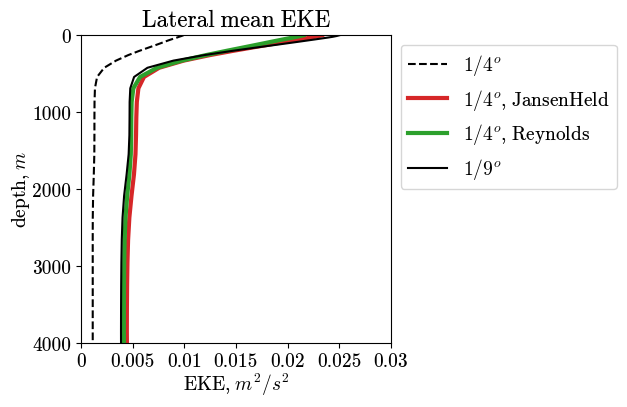

In [245]:
ds['R4'].plot_EKEz(label='$1/4^o$', color='k', ls='--')
ds['R4_neg'].plot_EKEz(label='$1/4^o$, JansenHeld', color='tab:red', lw=3)
ds['CR_30_2iter_4boundary'].plot_EKEz(label='$1/4^o$, Reynolds', color='tab:green', lw=3)
ds['R9'].plot_EKEz(label='$1/9^o$', color='k')
plt.legend(bbox_to_anchor=(1,1))

In [220]:
metrics().rank_metric('heat_flux')

{'CR_35_2iter_4boundary': '32.79 %',
 'CR_30_2iter_4boundary': '34.16 %',
 'R4_neg': '35.49 %',
 'CR_20': '36.73 %',
 'CR_25_3iter': '40.05 %',
 'CR_25_2iter_4boundary': '44.86 %',
 'CR_25': '45.71 %',
 'CR_35_2_iter': '53.42 %',
 'CR_25_2iter': '77.78 %',
 'CR_20_2iter': '83.69 %',
 'R4': '100.0 %'}

(-130000000000000.0, 50000000000000.0)

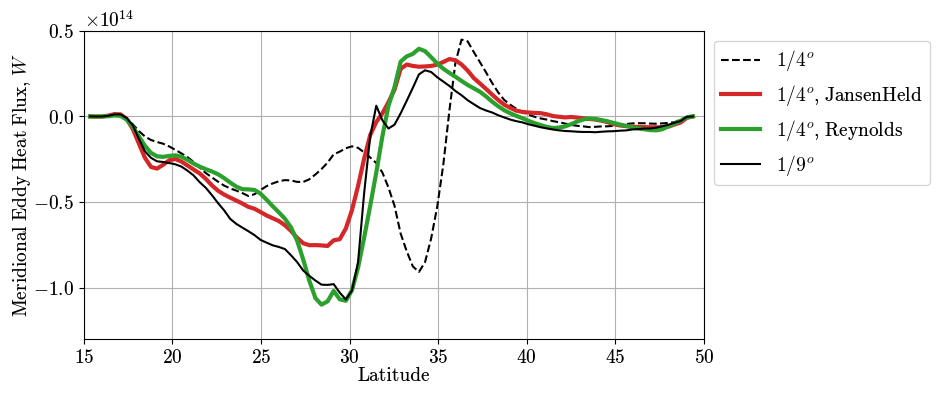

In [221]:
plt.figure(figsize=(8,4))
ds['R4'].heat_flux.plot(label='$1/4^o$', color='k', ls='--')
ds['R4_neg'].heat_flux.plot(label='$1/4^o$, JansenHeld', color='tab:red', lw=3)
ds['CR_35_2iter_4boundary'].heat_flux.plot(label='$1/4^o$, Reynolds', color='tab:green', lw=3)
ds['R9'].heat_flux.plot(label='$1/9^o$', color='k')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Latitude')
plt.ylabel('Meridional Eddy Heat Flux, $W$')
plt.grid()
plt.xlim([15,50])
plt.ylim([-1.3e+14,0.5e+14])

In [222]:
metrics().rank_metric('SST')

{'CR_25': '35.59 %',
 'CR_20': '41.28 %',
 'CR_25_3iter': '46.19 %',
 'CR_35_2iter_4boundary': '48.15 %',
 'CR_30_2iter_4boundary': '49.62 %',
 'CR_35_2_iter': '54.22 %',
 'CR_25_2iter_4boundary': '54.63 %',
 'R4_neg': '62.4 %',
 'CR_25_2iter': '63.37 %',
 'CR_20_2iter': '68.58 %',
 'R4': '100.0 %'}

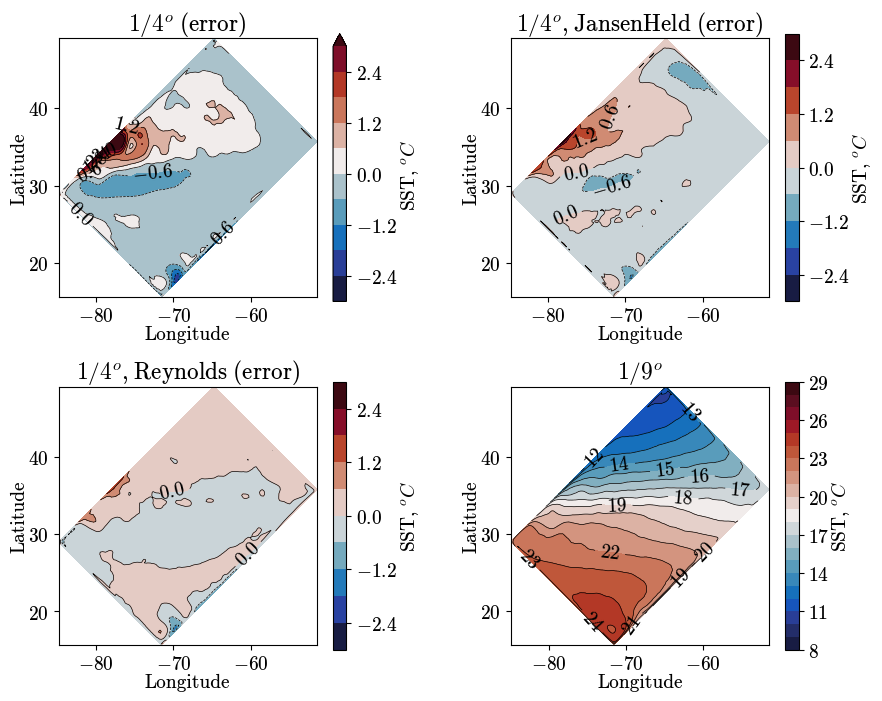

In [223]:
plot_2x2(fun='plot_SST', Reynolds='CR_25', error=True)

In [224]:
metrics().rank_metric('SSH')

{'CR_25': '44.83 %',
 'CR_20': '47.68 %',
 'CR_35_2iter_4boundary': '52.89 %',
 'CR_25_3iter': '54.53 %',
 'R4_neg': '55.82 %',
 'CR_30_2iter_4boundary': '56.36 %',
 'CR_25_2iter_4boundary': '64.44 %',
 'CR_35_2_iter': '66.36 %',
 'CR_25_2iter': '77.58 %',
 'CR_20_2iter': '83.76 %',
 'R4': '100.0 %'}

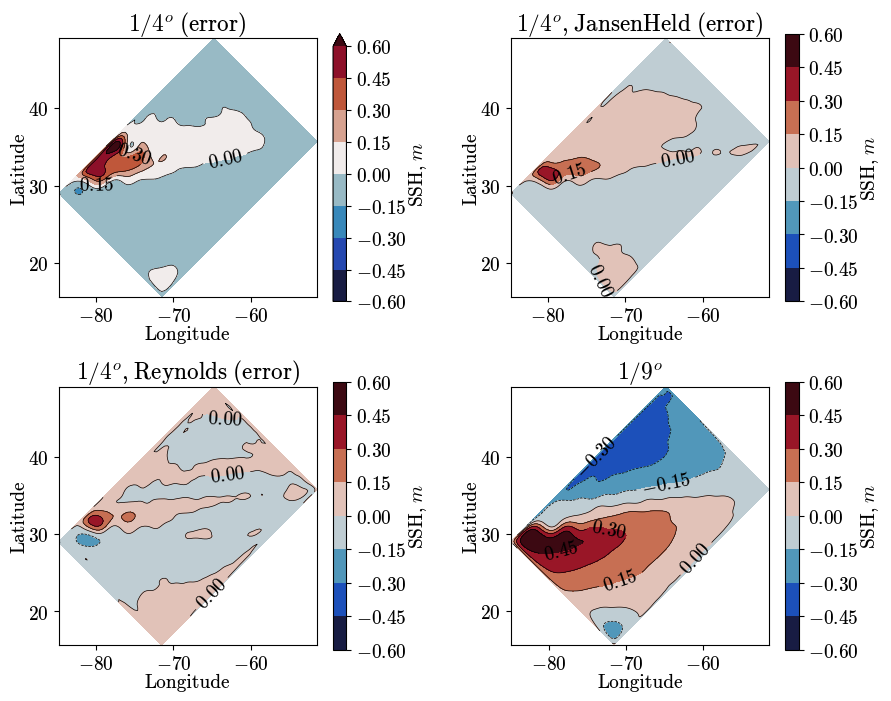

In [225]:
plot_2x2(fun='plot_SSH', Reynolds='CR_25', error=True)

In [226]:
metrics().rank_metric('uzonal_barotropic')

{'R4_neg': '78.5 %',
 'CR_35_2iter_4boundary': '84.66 %',
 'CR_20': '90.24 %',
 'CR_30_2iter_4boundary': '91.89 %',
 'CR_25_3iter': '99.66 %',
 'R4': '100.0 %',
 'CR_25': '100.58 %',
 'CR_25_2iter_4boundary': '100.81 %',
 'CR_20_2iter': '106.74 %',
 'CR_25_2iter': '106.76 %',
 'CR_35_2_iter': '108.37 %'}

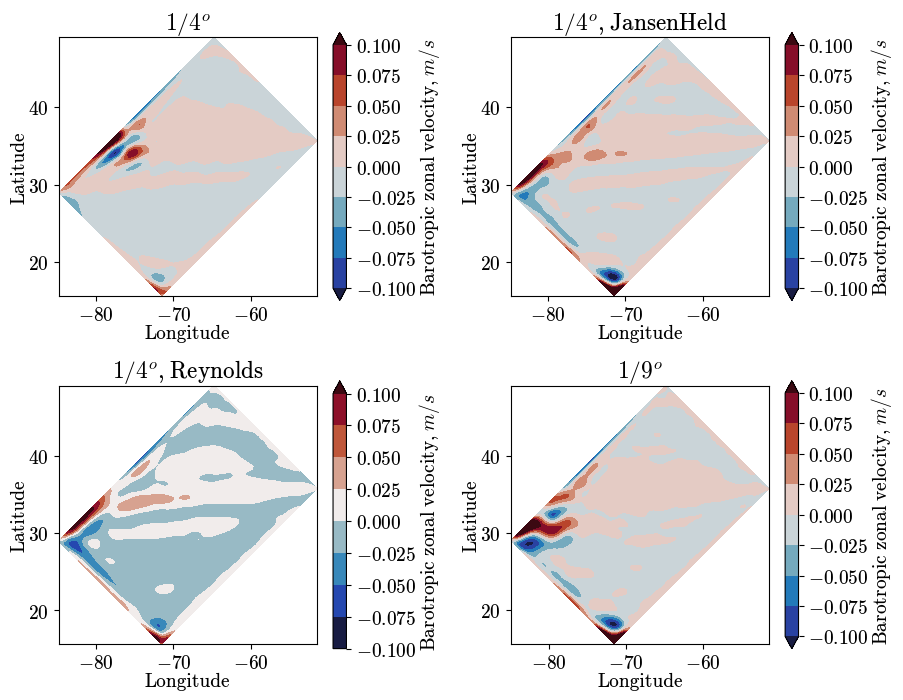

In [227]:
plot_2x2(fun='plot_uzonal', Reynolds='CR_35_2iter_4boundary')

In [228]:
metrics().rank_metric('uzonal_section')

{'R4_neg': '52.1 %',
 'CR_35_2iter_4boundary': '60.58 %',
 'CR_20': '61.76 %',
 'CR_30_2iter_4boundary': '67.88 %',
 'CR_25_3iter': '68.06 %',
 'CR_25_2iter_4boundary': '70.1 %',
 'CR_25': '72.34 %',
 'CR_35_2_iter': '72.55 %',
 'CR_20_2iter': '75.14 %',
 'CR_25_2iter': '81.39 %',
 'R4': '100.0 %'}

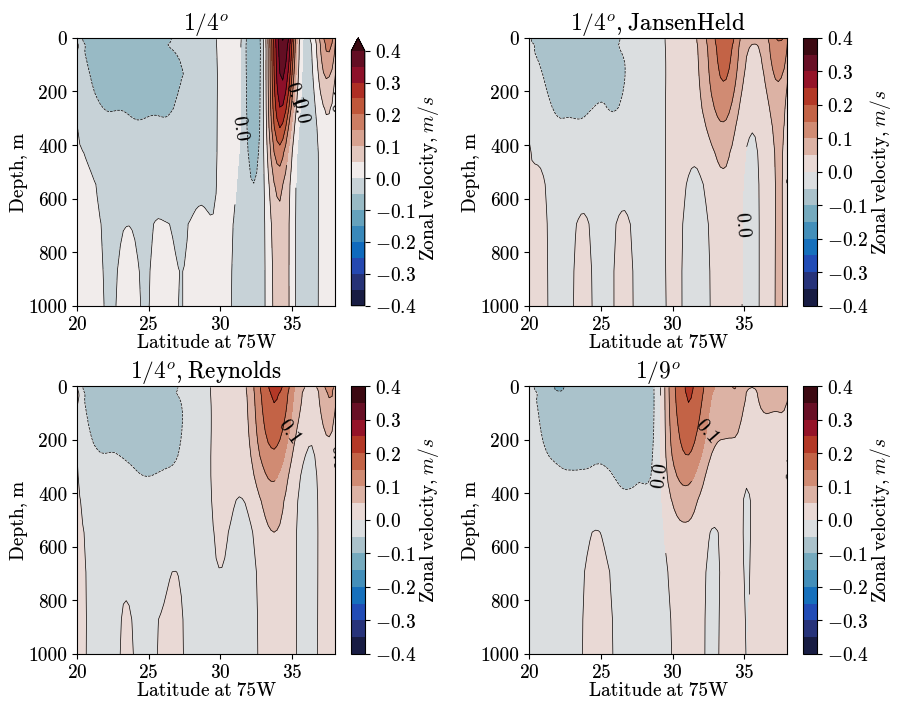

In [230]:
plot_2x2(fun='plot_uzonal_section', Reynolds='CR_35_2iter_4boundary')